### Code that can be ignored...

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import matplotlib.dates
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit

In [7]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': 'r', 'marker': 'o', 'ms': 10, 'alpha': 0.5}, 
         'WaterT [deg C]': {'color': 'b', 'marker': '.', 'ms': 10, 'alpha': 0.5}, 
         'Depth [m]': {'color': 'r', 'marker': 'o', 'ms': 10, 'alpha': 0.5},  
         'East [m/s]': {'color': 'g', 'marker': '>', 'ms': 10, 'alpha': 0.25}, 
         'North [m/s]': {'color': 'g', 'marker': '>', 'ms': 10, 'alpha': 0.25}, 
         'Salinity': {'color': 'k', 'marker': '*', 'ms': 10, 'alpha': 0.5}, 
         'Along [cm/s]': {'color': 'darkcyan', 'marker': '^', 'ms': 10, 'alpha': 0.5},
         'Across [cm/s]': {'color': 'darkcyan', 'marker': '^', 'ms': 10, 'alpha': 0.5},
         'Flow rate [m^3/s]': {'color': 'orange', 'marker':'s', 'ms': 10, 'alpha': 1},
         'Rain [cm]': {'color': 'purple', 'marker':'x', 'ms': 10, 'alpha': 1},
        }

base = 'drive_data/'

In [8]:
# read in buoy info
bys = pd.read_csv(base + 'buoys.csv', index_col=0).to_dict('index')

buoys = {'BOLI': {'ll': ([-94.783, 29.342]), 'color': '#689F38', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'MIDG': {'ll': ([-94.875, 29.508]),  'color': '#FBC02D', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'FISH': {'ll': ([-94.854, 29.670]),  'color': '#F57C00', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'TRIN': {'ll': ([-94.746, 29.661]),  'color': '#FFA000', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'OLDR': {'ll': ([-94.783, 29.833]), 'color': '#D32F2F', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         '08078000': {'ll': ([-95.32283, 29.3713056]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08077600': {'ll': ([-95.1783, 29.5172]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08074500': {'ll': ([-95.39694, 29.775]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08068500': {'ll': ([-95.4361, 30.110278]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08068090': {'ll': ([-95.3382, 30.141167]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08070500': {'ll': ([-95.302, 30.2594]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08071000': {'ll': ([-95.168056, 30.23250]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08070200': {'ll': ([-95.124167, 30.145278]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08071280': {'ll': ([-95.05972, 30.1094]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08067252': {'ll': ([-94.731, 29.812]), 'color': 'r', 'vars': ['Flow rate [m^3/s]']},
         '08067000': {'ll': ([-94.818056, 30.0575]), 'color': 'r', 'vars': ['Rain [cm]']},
         '08077650': {'ll': ([-94.92, 29.4472]), 'color': 'r', 'vars': ['Rain [cm]']},
         '08073600': {'ll': ([-95.55750, 29.76194]), 'color': 'r', 'vars': ['Rain [cm]']},
         '8771486': {'ll': ([bys['8771486']['lon'], bys['8771486']['lat']]),  'color': '#0097A7',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770613': {'ll': ([bys['8770613']['lon'], bys['8770613']['lat']]),  'color': '#E64A19',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                              'Salinity']},
         '8771013': {'ll': ([bys['8771013']['lon'], bys['8771013']['lat']]), 'color': '#AFB42B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                              'Salinity']},
         '8771341': {'ll': ([bys['8771341']['lon'], bys['8771341']['lat']]), 'color': '#388E3C',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                             'AtmPr [MB]']},
         '8771450': {'ll': ([bys['8771450']['lon'], bys['8771450']['lat']]), 'color': '#00796B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                             'AtmPr [MB]']},
         'B': {'ll': ([bys['B']['lon'], bys['B']['lat']]), 'color': '#303F9F',
                     'vars': ['AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]', 'Salinity', 
                              'Along [cm/s]', 'Across [cm/s]']},
         'g06010': {'ll': ([bys['g06010']['lon'], bys['g06010']['lat']]), 'color': '#388E3C',
                     'vars': ['Along [cm/s]', 'Across [cm/s]', 'WaterT [deg C]']},
         '42035': {'ll': ([bys['42035']['lon'], bys['42035']['lat']]), 'color': '#5D4037',
                     'vars': ['AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770808': {'ll': ([bys['8770808']['lon'], bys['8770808']['lat']]), 'color': '#512DA8',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770777': {'ll': ([bys['8770777']['lon'], bys['8770777']['lat']]), 'color': '#C2185B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770822': {'ll': ([bys['8770822']['lon'], bys['8770822']['lat']]), 'color': '#455A64',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770971': {'ll': ([bys['8770971']['lon'], bys['8770971']['lat']]), 'color': '#7B1FA2',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8771972': {'ll': ([bys['8771972']['lon'], bys['8771972']['lat']]), 'color': '#0288D1',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']}
        }


buoys_ordered = ['8770777', '8770613', 'OLDR', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341',
                '8771450', '8771486', '8771972', '8770971', '8770808', 'B', '42035', '8770822']
# buoys down main bay
buoys_main = ['8770613', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341', '8771450']
# buoys used in analysis
buoys_used = ['MIDG', '8771013', 'g06010', 'BOLI', '8771486', '8771341', '8770613', '8771972']

In [9]:
# See make_data notebook. This reads in data from many sources, recalculates so that all data is hourly by taking 
# hourly averages, and shifts water levels to all be mean high water to match the bathymetry.
df = pd.read_csv(base + 'data.csv', parse_dates=True, index_col=0)

dstart = '2017-06-01'; dend = '2017-12-31'

In [10]:
saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]
saltcols

['FISH: Salinity',
 'MIDG: Salinity',
 'TRIN: Salinity',
 'BOLI: Salinity',
 '8770613: Salinity',
 '8771013: Salinity']

In [13]:

for col in saltcols:
    df[col + ' (log)'] = np.log(df[col])
    
# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())


# Introduction to salinity reintroduction timescales

The goal in this work is to provide context for the biological and chemical measurements that were made in the weeks after Hurricane Harvey in Galveston Bay. The samples showed a change from marine to non-marine organisms and a return to marine that varied in time and space in the Bay. Giving spatial information about the timescale of return to marine conditions in the bay will help with interpretation of the changes in population seen.

So, I want to give a spatially-varying timescale for the reintroduction of salinity to Galveston Bay after it has been completely freshened by floodwaters. 


## Theoretical model

For each salinity station, we assume locally input source water at a constant salinity, $S_\infty$ that is instantaneously locally mixed. The flow rate of water, $Q$, into and out of the local, unbounded region of constant volume $V$ is equal and constant, and the resultant salinity which changes in time is $S(t)$ (see image). $S_\infty$ is different for each station.

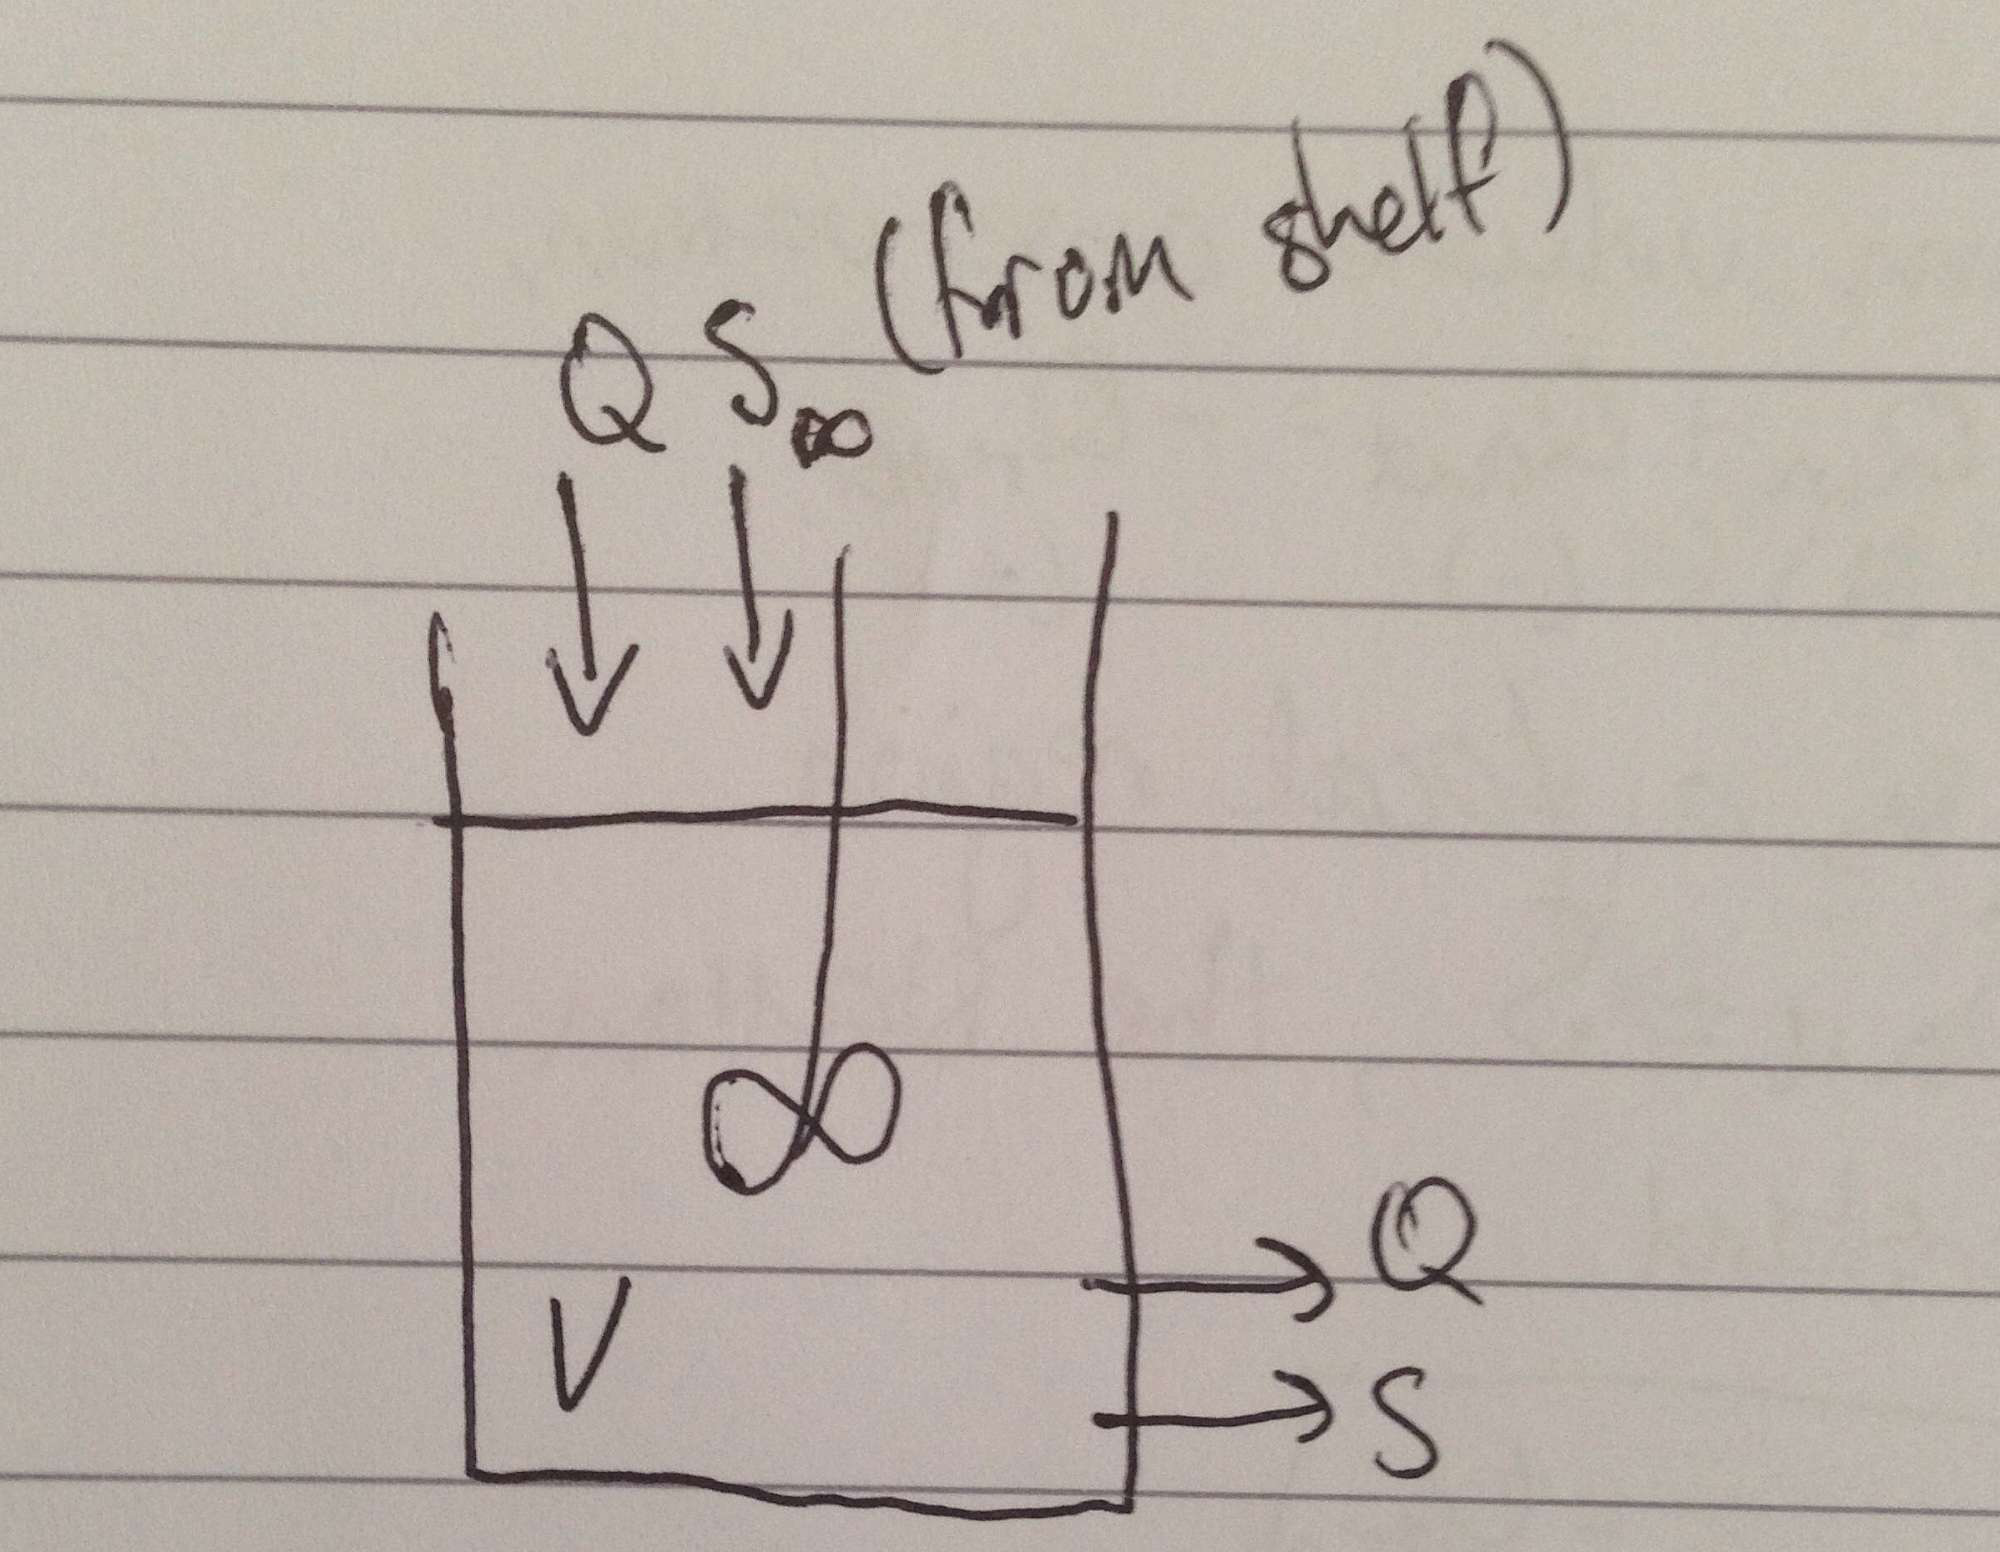


Using the fact that the salinity introduction timescale, $\tau_s$, has the following relationship: $\tau_s = \frac{V}{Q}$, the following is conservation of salinity in this region:

$
\begin{align}
    \frac{d(SV)}{dt} &= QS_\infty - QS \\
    \frac{dS}{dt} &= \frac{1}{\tau_s}(S_\infty - S) \\
    \Rightarrow S(t) &= S_\infty (1-e^{-t/\tau_s}) ~~~~~~(1)
\end{align}
$

**Question:** Is it legitimate to use the theory this way in an unbounded region?

## Linear fit to logscale

I first solved Equation 1 for $\tau_s$ to get:

$
\begin{align}
    \tau_s &= -\frac{1}{\ln|1-S/S_\infty|} t
\end{align}
$

then fit a straight line to the function in log space. The results were not very robust since the salinity is close to zero after the flooding, which makes $\tau_s$ blow up in this form. Perhaps I could transform the equation, run the fit, and transform it back to avoid this problem. Instead I switched to fit the exponential directly (next section).


## Exponential fit

I used non-linear least squares to fit Equation 1 to solve for $\tau_s$ and $S_\infty$ (I needed to include limiting bounds on the parameters to keep them in a reasonal range of values).

I have several questions about the choice of start and stop time for fitting the salinity data which I think could be answered with a better understanding of the theory. The timescale is supposed to be information about time to get back to "normal" conditions, but what counts as normal in a continuously-varying system?

**Questions:**
* I'm showing this analysis allowing for different start times for each station based on when the salinity started to increase from zero, but the end time is the same for all the stations (Oct 22nd). Is this reasonable?
* Alternative approaches I have tried:
 * Used a different uniform end date for all stations (e.g. tried Oct 29th, Nov 5th, Nov 12)
 * Allowed the end date to vary with different criteria:
   * When a given station seems to "level out" after the hurricane. But, some stations never really do and some do but multiple times.
   * When a given station returns to the mean value of the salinity over a time period before the flooding.
   
In the plot, the vertical gray line is what I am counting as the start of when salinity could be reintroduced (or the end of the flooding).

In [16]:
# times = {'FISH': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-5 00:00']},
#         'MIDG': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-5 00:00']},
#         'TRIN': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-5 00:00']},
#         'BOLI': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-5 00:00']},
#         '8770613': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-5 00:00']},
#         '8771013': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-5 00:00']}}

# times = {'FISH': {'starts': ['2017-9-10 12:00'], 'stops': ['2017-10-27 00:00']},
#         'MIDG': {'starts': ['2017-9-2 00:00'], 'stops': ['2017-11-7 00:00']},
#         'TRIN': {'starts': ['2017-9-16 12:00'], 'stops': ['2017-10-28 00:00']},
#         'BOLI': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-11-1 00:00']},
#         '8770613': {'starts': ['2017-9-5 00:00'], 'stops': ['2017-10-17 00:00']},
#         '8771013': {'starts': ['2017-9-12 00:00'], 'stops': ['2017-10-22 00:00']}}

times = {'FISH': {'starts': ['2017-9-12 12:00'], 'stops': ['2017-10-22 00:00']},
        'MIDG': {'starts': ['2017-9-2 00:00'], 'stops': ['2017-10-22 00:00']},
        'TRIN': {'starts': ['2017-9-16 12:00'], 'stops': ['2017-10-22 00:00']},
        'BOLI': {'starts': ['2017-9-1 00:00'], 'stops': ['2017-10-22 00:00']},
        '8770613': {'starts': ['2017-9-5 00:00'], 'stops': ['2017-10-22 00:00']},
        '8771013': {'starts': ['2017-9-12 00:00'], 'stops': ['2017-10-22 00:00']}}


15.1201468121 38.0598230914 13
14.6321387395 14.1913693051 3
8.94503958938 25.2325161359 17
21.2606663547 12.4525479298 2
14.2599821289 26.0358554843 6
9.67071336983 9.77825467899 13


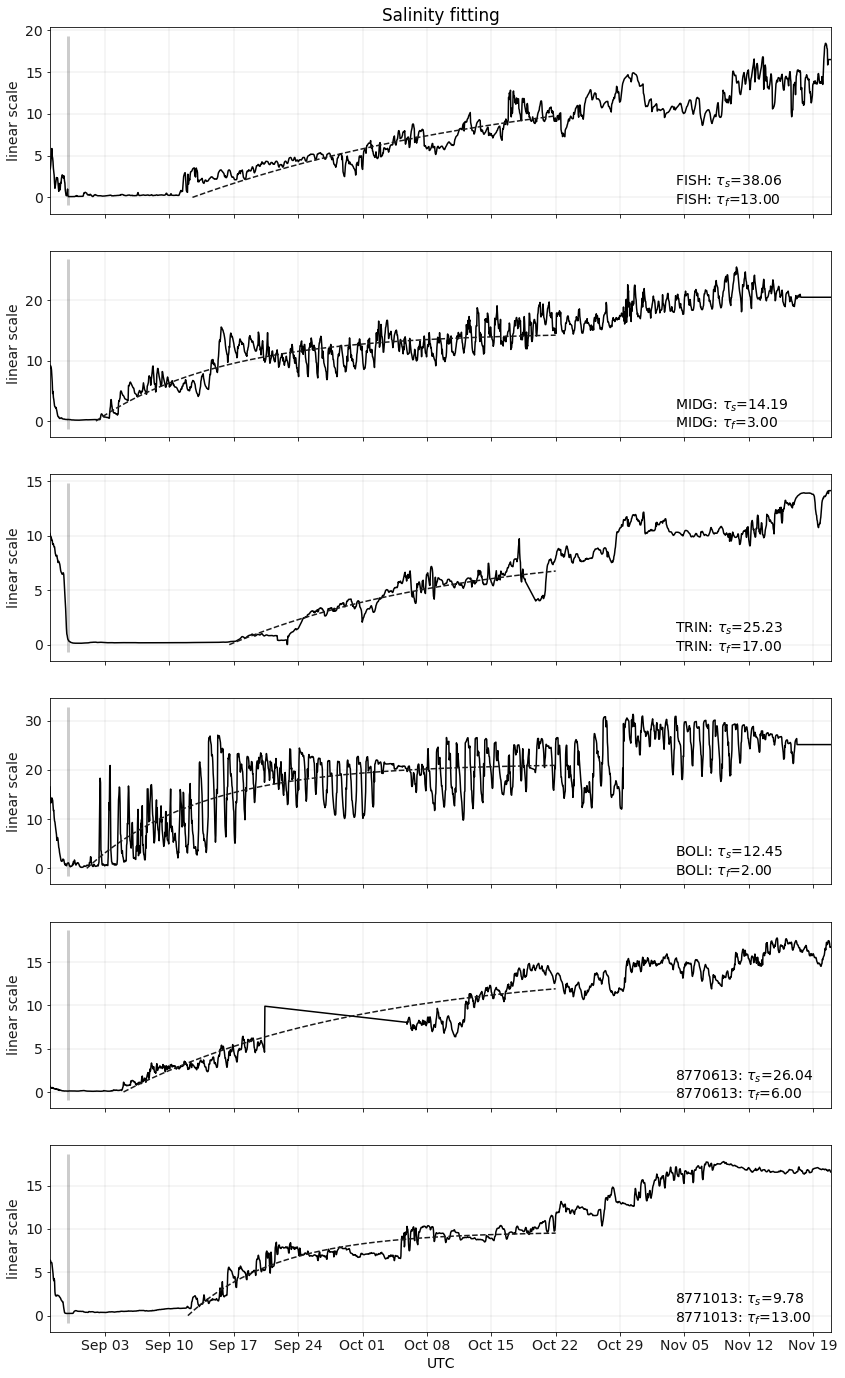

In [17]:
dst = '2017-8-28'; den = '2017-11-20'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(14,24), sharex=True)

tau = []; Sinf = []; tauf = []
for col, ax in zip(saltcols, axes):
    
    name = col.split(':')[0]
#     Sinf = df[col]['2017-11-1':'2017-11-10'].mean()
#     Sinf = df[col]['2017-8-1':'2017-8-20'].mean()
    def recovery(t, Sinf, tau):
        '''exponential function.'''

        return Sinf*(1-np.exp(-t/tau))
    
    for i, (start, stop) in enumerate(zip(times[name]['starts'], times[name]['stops'])):
        
        # get fit
        d1 = start; d2 = stop
        tnums = df['idx'][d1:d2] - df['idx'][d1]
        fit = curve_fit(recovery, tnums, df[col][d1:d2].interpolate(), bounds=(0,90))
        data_fit = recovery(tnums, *fit[0])
        Sinf.append(fit[0][0])
        tau.append(fit[0][1])
        # how long fresh
        tauf.append((pd.Timestamp(d1) - pd.Timestamp('2017-8-30 00:00')).days)
        print(Sinf[-1],tau[-1], tauf[-1])
  
        # linear
        color = '0.1'
        if i == 0:
            ax.plot(df[col][dst:den].interpolate(), 'k')
        ax.plot(data_fit.index, data_fit, '--', color=color)  # plot fit
        ax.tick_params(labelcolor=color)
        ax.set_ylabel('linear scale', color=color)

        # write station name and tau
        ax.text(0.8, 0.15 - i*0.1, name + r': $\tau_s$=%1.2f' % tau[-1], transform=ax.transAxes)
        ax.text(0.8, 0.15 - 0.1, name + r': $\tau_f$=%1.2f' % tauf[-1], transform=ax.transAxes)

        ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
        ax.grid(which='minor', lw=1, color='k', alpha=0.05)
        
        ylims = ax.get_ylim()
        ax.vlines('2017-8-30 00:00', *ylims, lw=3, alpha=0.2)
    
days = mpl.dates.DayLocator(interval=7)
ax.xaxis.set_major_locator(days)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))

axes[0].set_title('Salinity fitting')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)

fig.savefig('figures/salinity_reintroduction.pdf', bbox_inches='tight')
fig.savefig('figures/salinity_reintroduction.png', bbox_inches='tight')


### Two timescales

There are two important time scales here:

1. time before salinity reintroduction
1. timescale of salinity reintroduction

The overall timescale should be a combination of the two, something like:

$ \tau = \tau_{f} + P*\tau_{s} $,

where $\tau_s$ is the timescale in the exponential describing salinity reintroduction, $\tau_f$ is the timescale describing how long the station stayed fresh, and $P$ is the percent back to "normal" the salinity is, out of 100%. For example, we see the following:

$
\begin{align}
    &S(t) = S_\infty (1-e^{-t/\tau_s}) \\
    &S(0) = 0 \\
    &S(\tau_s) = 63\% S_{\infty} \\
    &S(3\tau_s) = 95\% S_{\infty} \\
    &S(5\tau_s) = 99\% S_{\infty}
\end{align}
$

So, a station is back to 63% salinity after time $t=\tau_s$, giving an overall timescale $\tau$ of:

$\tau = \tau_{f} + \tau_{s}$.

A station is back to 95% salinity after time $t=3*\tau_s$, giving an overall timescale of

$\tau = \tau_{f} + 3\tau_{s}$.


### Results

#### Time to 63% salinity return

In [25]:
for col, taf, ta in zip(saltcols, tauf, tau):
    
    name = col.split(':')[0]
    state = 'Station %s time to .63 salinity is %d days' % (name, taf+ta)
    print(state)


Station FISH time to .63 salinity is 51 days
Station MIDG time to .63 salinity is 17 days
Station TRIN time to .63 salinity is 42 days
Station BOLI time to .63 salinity is 14 days
Station 8770613 time to .63 salinity is 32 days
Station 8771013 time to .63 salinity is 22 days


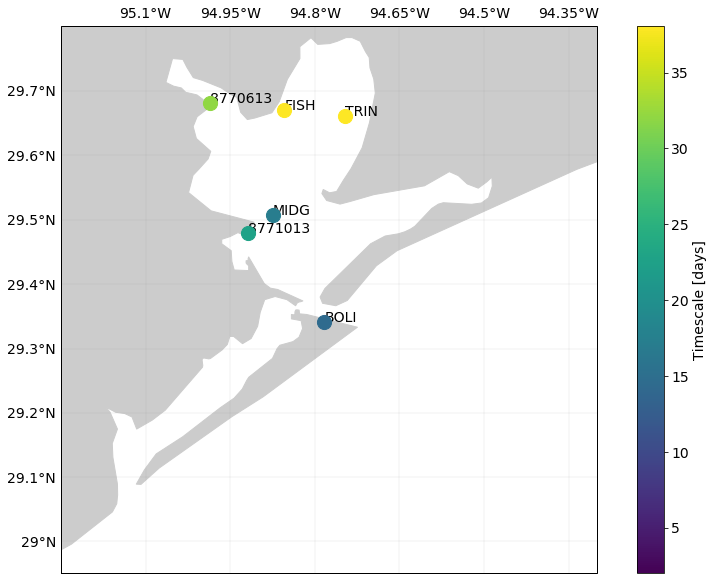

In [29]:
base = 'drive_data/'
d = np.load(base + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(base + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.25, -94.3, 28.95, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

# plot buoys
vmin = min(tauf+tau); vmax = max(tauf+tau)
for saltcol, ta, taf in zip(saltcols, tau, tauf):
    buoy = saltcol.split(':')[0]
    param = taf+ta
    mappable = ax.scatter(*buoys[buoy]['ll'], c=param, s=200, transform=pc, zorder=10, vmin=vmin, vmax=vmax)
    ax.text(*buoys[buoy]['ll'], buoy, transform=pc)
cb = plt.colorbar(mappable)
cb.set_label('Timescale [days]')

#### Time to 95% salinity return

In [24]:
for col, taf, ta in zip(saltcols, tauf, tau):
    
    name = col.split(':')[0]
    state = 'Station %s time to .95 salinity is %d days' % (name, taf+3*ta)
    print(state)


Station FISH time to .95 salinity is 127 days
Station MIDG time to .95 salinity is 45 days
Station TRIN time to .95 salinity is 92 days
Station BOLI time to .95 salinity is 39 days
Station 8770613 time to .95 salinity is 84 days
Station 8771013 time to .95 salinity is 42 days


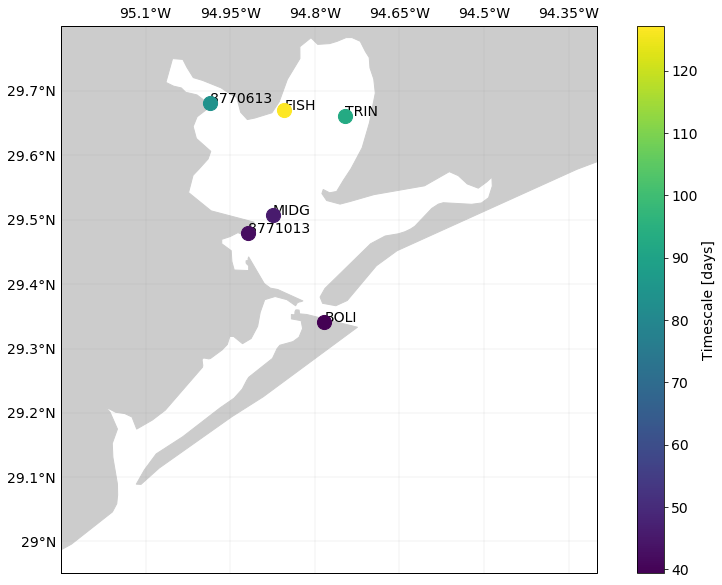

In [30]:
base = 'drive_data/'
d = np.load(base + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(base + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.25, -94.3, 28.95, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

# plot buoys
vmin = min(tauf+3*np.asarray(tau)); vmax = max(tauf+3*np.asarray(tau))
for saltcol, ta, taf in zip(saltcols, tau, tauf):
    buoy = saltcol.split(':')[0]
    param = taf+3*ta
    mappable = ax.scatter(*buoys[buoy]['ll'], c=param, s=200, transform=pc, zorder=10, vmin=vmin, vmax=vmax)
    ax.text(*buoys[buoy]['ll'], buoy, transform=pc)
cb = plt.colorbar(mappable)
cb.set_label('Timescale [days]')

## Interpretation

The relative timescales for the stations for 63% return make sense to me because the general model of salinity into the Bay is from the main entrance channel, down the ship channel, and then mixing in with Trinity Bay water. Therefore, we'd expect the Trinity Bay stations to have the longest timescales, which is what we see.

There was much less freshwater coming into Trinity Bay than from the San Jacinto (from Houston, which is the opposite of usual), but I am not sure that is related to the work here. 

The 95% return results show the FISH station having a very long timescale. I suspect this is more due to the method used than actuality. 

**Question:** How can make this more robust so all stations have reasonable values?